# Summarizing metrics from disturbed XS +z

Leanne Friedrich 4/26/23

## initialization

In [1]:
%load_ext autoreload
%autoreload 2
LOGGERDEFINED = False

In [2]:
import os
import sys
sys.path.append("../")
sys.path.append("../../")
from py.tools.config import cfg
import py.tools.logs as logs
from plainIm import plainIm
import matplotlib.pyplot as plt
import py.metrics.m_plot.m_plots as mp
import py.metrics.m_SDT as me
import regression as rg
import matplotlib.cm as cm
import py.file.file_handling as fh
LOGGERDEFINED = logs.openLog('summary_xsz_SDT.ipynb', LOGGERDEFINED, level='DEBUG', exportLog=False)

## analyzing data

In [3]:
ms = me.summarySDT(os.path.join(cfg.path.fig, 'SDT', 'summaries', 'XS+zSDTSummaries.csv')
                             , diag=True)

Independents: 
	 meta        :  bn, calibFile, fluFile, printFolderR
	                date
	 meta sup    :  sup_base, sup_days, sup_dye, sup_rheModifier, sup_shortname, sup_surfactant, sup_surfactantWt, sup_type, sup_var
	 meta ink    :  ink_base, ink_days, ink_dye, ink_rheModifier, ink_shortname, ink_surfactant, ink_surfactantWt, ink_type, ink_var
	 const       :  GaRatio, GdRatio, gname, GtaRatio, int_Ca, int_CaInv, int_Re, ReRatio, tau0aRatio, tau0dRatio, tGdRatio, viscRatio, vRatio
	                dEst, hDragP, pressureCh0, rGrava, rGravd, sigma, spacing, spacing_adj, vDragP, zdepth
	 const sup   :  sup_Bma, sup_Bmd, sup_Ca, sup_CaInv, sup_diluent, sup_diluentWt, sup_dnorma, sup_dnorma_adj, sup_dnormd, sup_dnormd_adj, sup_dnormInva, sup_dnormInvd, sup_Oh, sup_OhInv, sup_Re, sup_We, sup_WeInv
	                sup_density, sup_dPRa, sup_dPRd, sup_eta0a, sup_eta0d, sup_Gstora, sup_Gstord, sup_rate, sup_tau0a, sup_tau0d, sup_v, sup_val, sup_visc0
	 const ink   :  ink_Bma, ink_Bmd, ink

,1,2,3
wp,X_w1p,X_w2p,X_w3p
wo,X_w1o,X_w2o,X_w3o
wrelax,delta_X_w1relax,delta_X_w2relax,delta_X_w3relax
write,delta_X_write1,delta_X_write2,
dp,X_d1p,X_d2p,
do,X_d1o,X_d2o,
drelax,delta_X_d1relax,delta_X_d2relax,
disturb,delta_X_disturb1,delta_X_disturb2,


In [4]:
ms.ss.sigma.unique()

array([33.6558    ,  7.905     , 37.8013    ,  1.7649    , 15.43863469])

In [14]:
import numpy as np
import pandas as pd

In [15]:
out = []
for i,row in ms.ss.iterrows():
    d = {}
    d['derr'] = 0.001  # mm
    d['dierrfrac'] = d['derr']/0.6
    d['dserrfrac'] = d['derr']/0.9
    d['desterr'] = 0.01 # mm
    d['desterrfrac'] = d['desterr']/row['dEst']
    d['dacterr'] = 0.014  # mm
    d['dacterrfrac'] = d['dacterr']/row['dEst']
    d['Derr'] = 0.0064 # mm
    d['verr'] = 0.01 # mm/s
    d['sigma'] = row['sigma']  # mN/m
    d['sigmaerr'] = {33.6558:0.228794, 7.905:0.107424, 37.8013:0.03415, 1.7649:0.003311, 15.43863469:2.970641}[d['sigma']]  # mN/m
    d['sigmaerrfrac'] = d['sigmaerr']/d['sigma']
    d['spacingerr'] = np.sqrt(d['derr']**2+d['desterr']**2) 
    d['spacingadjerr'] = np.sqrt(d['derr']**2+d['dacterr']**2)
    d['rhoerr'] = 0.1 # g/mL
    d['rhoerrfrac'] = d['rhoerr']/row['ink_density']
    for fluid in ['i', 's']:
        
        ful = {'i':'ink', 's':'sup'}[fluid]
        d[f'v{fluid}errfrac'] = d['verr']/row[f'{ful}_v']
        d[f'eta{fluid}'] = row[f'{ful}_eta0d']
        d[f'eta{fluid}errfrac'] = d[f'eta{fluid}']*0.03
        d[f'Ca{fluid}errfrac'] = np.sqrt(0.03**2 + d[f'v{fluid}errfrac']**2+d['sigmaerrfrac']**2)
        d[f'Oh{fluid}errfrac'] = np.sqrt(0.03**2 + 1/2*d['rhoerrfrac']**2 + 1/2*d[f'd{fluid}errfrac']**2) 
        d[f'Re{fluid}errfrac'] = np.sqrt(d['rhoerrfrac']**2 + d[f'v{fluid}errfrac']**2+ d[f'd{fluid}errfrac']**2+0.03**2)
        d[f'We{fluid}errfrac'] = np.sqrt(d['rhoerrfrac']**2 + d[f'v{fluid}errfrac']**2+ d['sigmaerrfrac']**2+0.03**2)
        for dire in ['a', 'd']:
            d[f'tauy{fluid}{dire}'] = row[f'{ful}_tau0{dire}']
            d[f'tauy{fluid}{dire}errfrac'] = d[f'tauy{fluid}{dire}']*0.08
            d[f'Bm{fluid}{dire}errfrac'] = np.sqrt(0.08**2+d[f'd{fluid}errfrac']**2+0.03**2+d[f'v{fluid}errfrac']**2)
            for dd in ['e', 'a']:
                der = {'e':'desterrfrac', 'a':'dacterrfrac'}[dd]
                d[f'DR{fluid}{dire}{dd}errfrac'] = np.sqrt(d[der]**2 + 0.08**2 +  d['sigmaerrfrac']**2)
    out.append(d)
df1 = pd.DataFrame(out)

In [23]:
df1.to_csv(os.path.join(cfg.path.fig, 'SDT', 'summaries', 'errors.csv'))

In [21]:
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min()*100,x.max()*100])


df2 = df1.apply(minMax).transpose()
df2.sort_index()

,min,max
Bmiaerrfrac,8.55,8.55
Bmiderrfrac,8.55,8.55
Bmsaerrfrac,8.55,8.55
Bmsderrfrac,8.55,8.55
Caierrfrac,3.00,19.47
Caserrfrac,3.00,19.47
DRiaaerrfrac,8.33,20.97
DRiaeerrfrac,8.17,20.90
DRidaerrfrac,8.33,20.97
DRideerrfrac,8.17,20.90


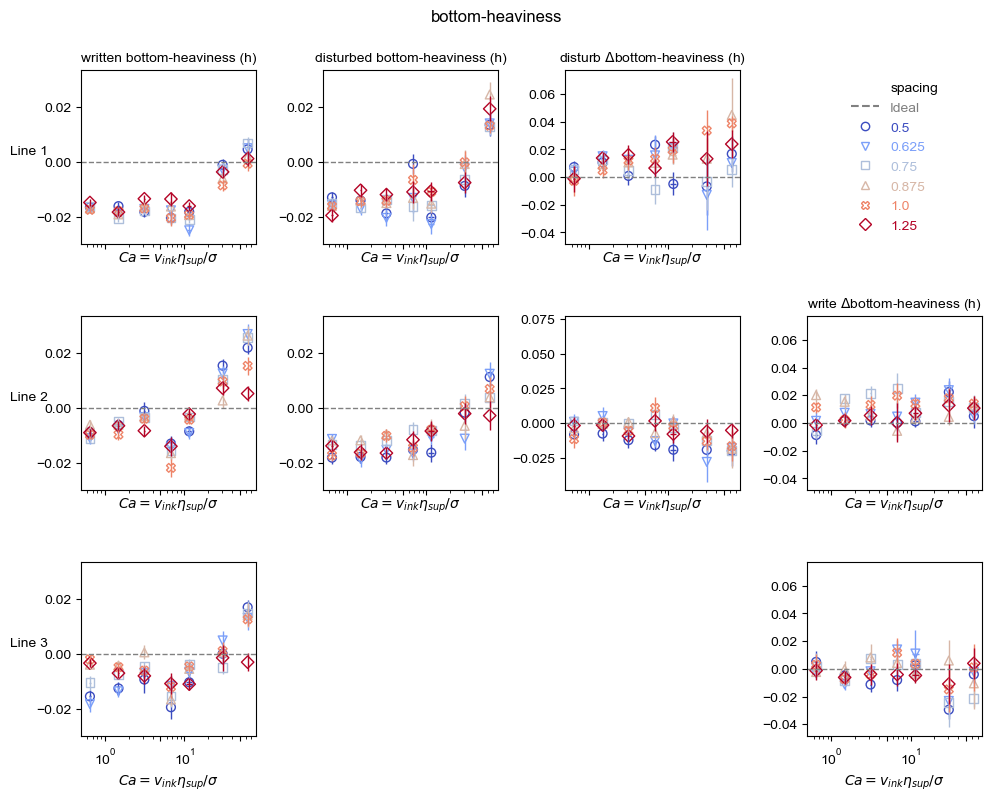

In [22]:
yvl = mp.yvarlines(ms, ms.ss, xvar='int_Ca', yvar='yshift', cvar='spacing', llist=[1, 2, 3]
             , plist=['wo', 'do', 'disturb', 'write'], plotType='notebook', yideal=me.XSSDTIdeals('+z')
                   , logx=True, mode='scatter', dx=0.15)
yvl.fig

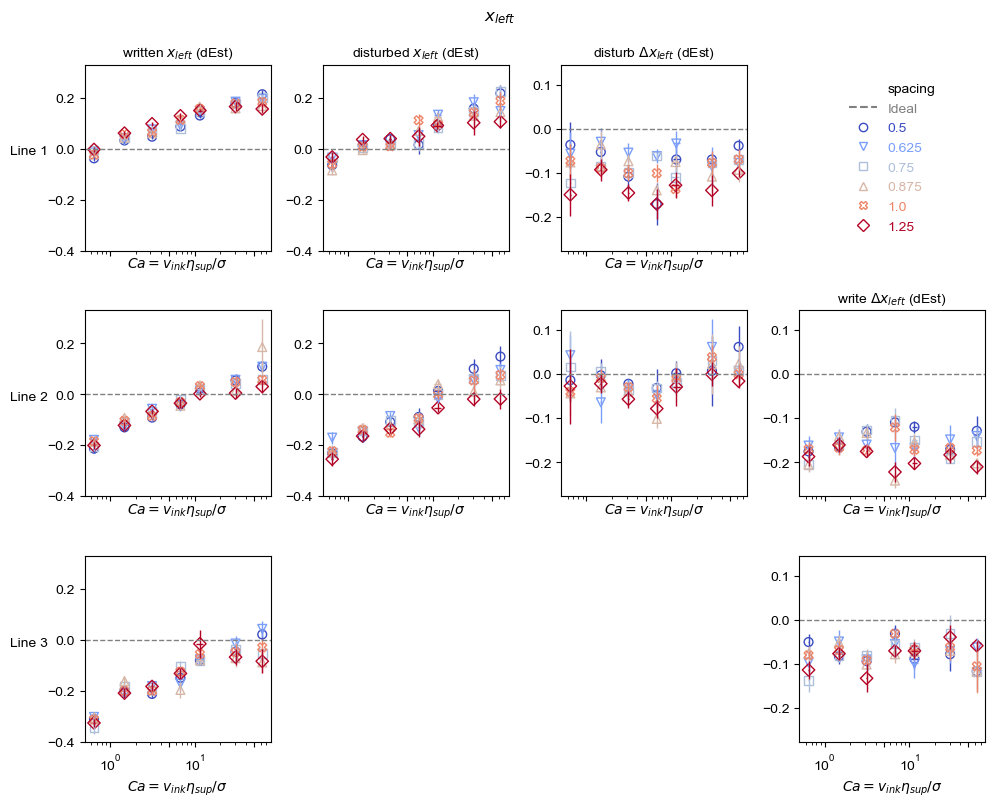

In [10]:
yvl = mp.yvarlines(ms, ms.ss, xvar='int_Ca', yvar='xLeft', cvar='spacing', llist=[1, 2, 3]
             , plist=['wo', 'do', 'disturb', 'write'], plotType='notebook', yideal=me.XSSDTIdeals('+z')
                   , logx=True, mode='scatter', dx=0.15)
yvl.fig

In [7]:
ms.reduceRows('delta_yTop_write3', yvarmin=0.5)

,ink_shortname,sup_shortname,int_Ca,spacing,delta_yTop_write3
196,PDMSS6-S85-0.05,4.0,14.00,1.00,0.50
856,SO9-S85-0.05,4.0,7.17,0.50,0.50
446,SO9,3.0,0.62,0.75,0.58
66,PDMSS12.5,3.0,0.70,0.50,0.64
374,SO11,3.0,0.62,0.75,0.68
645,SO7-S20-0.5,4.0,62.72,0.88,0.91
573,SO6-S20-0.5,3.5,30.35,0.88,1.26
53,PDMSS10,4.0,3.29,1.25,2.09
339,SO10,4.0,2.93,0.88,2.73
193,PDMSS6-S85-0.05,4.0,14.00,0.62,4.28


In [14]:
ms.openFolder(66)

INFO: Exported C:/Users/lmf1/OneDriveNIST/NIST/data/shopbot/results\SDT\plots\shift_xs3_HOP.png and .svg


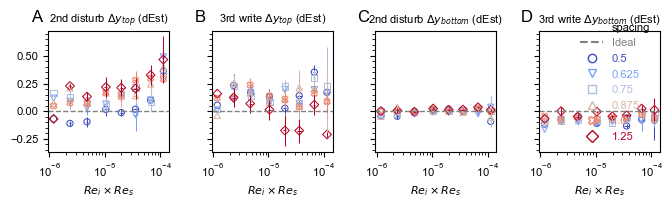

In [16]:
yvl = mp.shiftPlot3XS(ms, 'HOP', xvar='ReProd', export=True)
yvl.fig

# regressions

In [5]:
def exportRegression(var, **kwargs) -> None:
    mp.regressionTableSDT(ms, ms.ss, var, logy=False, printOut=False,  package='tabularShort', trimVariables=False
                            , plot=True, yideal=me.ideals(), plotType='paper', export=True, tag='HOPx', exportFolder=os.path.join(cfg.path.fig, 'SDT'), **kwargs)

In [14]:
exportRegression('delta_yBot_disturb2')
exportRegression('delta_yBot_disturb2', spacing=1.25)
exportRegression('delta_yBot_write3')

exportRegression('delta_yTop_disturb2')
exportRegression('delta_yTop_write3')

INFO: Exported C:/Users/lmf1/OneDriveNIST/NIST/data/shopbot/results\SDT\regressionTables\tab_delta_yBot_disturb2_HOPx_Reg.tex
INFO: Exported C:/Users/lmf1/OneDriveNIST/NIST/data/shopbot/results\SDT\plots\regression\fig_delta_yBot_disturb2_HOPx_Reg.png and .svg
INFO: Exported C:/Users/lmf1/OneDriveNIST/NIST/data/shopbot/results\SDT\regressionTables\tab_delta_yBot_disturb2_HOPx_1250_Reg.tex
INFO: Exported C:/Users/lmf1/OneDriveNIST/NIST/data/shopbot/results\SDT\plots\regression\fig_delta_yBot_disturb2_HOPx_1250_Reg.png and .svg
INFO: Exported C:/Users/lmf1/OneDriveNIST/NIST/data/shopbot/results\SDT\regressionTables\tab_delta_yBot_write3_HOPx_Reg.tex
INFO: Exported C:/Users/lmf1/OneDriveNIST/NIST/data/shopbot/results\SDT\plots\regression\fig_delta_yBot_write3_HOPx_Reg.png and .svg
INFO: Exported C:/Users/lmf1/OneDriveNIST/NIST/data/shopbot/results\SDT\regressionTables\tab_delta_yTop_disturb2_HOPx_Reg.tex
INFO: Exported C:/Users/lmf1/OneDriveNIST/NIST/data/shopbot/results\SDT\plots\regress

In [15]:
exportRegression('delta_yTop_disturb2', spacing=0.5)
exportRegression('delta_yTop_write3', spacing=0.5)

INFO: Exported C:/Users/lmf1/OneDriveNIST/NIST/data/shopbot/results\SDT\regressionTables\tab_delta_yTop_disturb2_HOPx_500_Reg.tex
INFO: Exported C:/Users/lmf1/OneDriveNIST/NIST/data/shopbot/results\SDT\plots\regression\fig_delta_yTop_disturb2_HOPx_500_Reg.png and .svg
INFO: Exported C:/Users/lmf1/OneDriveNIST/NIST/data/shopbot/results\SDT\regressionTables\tab_delta_yTop_write3_HOPx_500_Reg.tex
INFO: Exported C:/Users/lmf1/OneDriveNIST/NIST/data/shopbot/results\SDT\plots\regression\fig_delta_yTop_write3_HOPx_500_Reg.png and .svg


## ytop

In [11]:
rgt = mp.regressionTableSDT(ms, ms.ss, 'delta_yTop_disturb2', spacing=1.25, logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

,variable,Spearman coeff,Spearman p
19,$DR_{sda}$,-0.49,4.15e-04


In [13]:
rgt = mp.regressionTableSDT(ms, ms.ss, 'delta_yTop_write3', spacing=0.5, logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

,variable,Spearman coeff,Spearman p
21,$DR_{ida}/DR_{sda}$,0.2,0.18


## w

,variable,Spearman coeff,Spearman p
1,$Oh_{sup}$,-0.43,1.0e-40


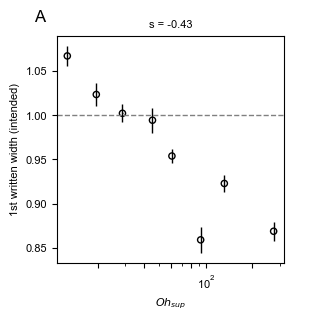

In [65]:
rgt = mp.regressionTableSDT(ms, ms.ss, 'w_w1o', logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

,variable,Spearman coeff,Spearman p
0,spacing,-0.56,3.6e-04
1,spacing_adj,-0.61,8.5e-05
2,$\overline{d_{PR.ink.desc}}$,-0.52,1.1e-03


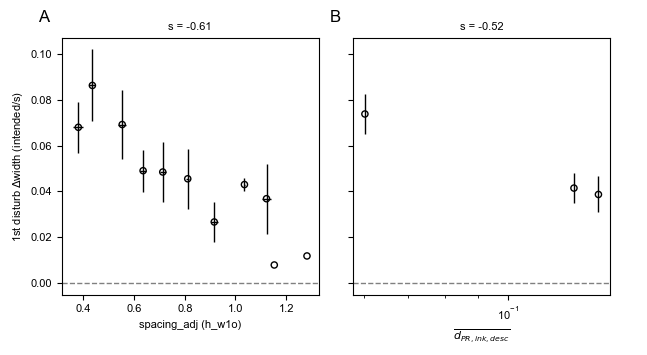

In [63]:
rgt = mp.regressionTableSDT(ms, ms.ss[ms.ss.int_Ca>15], 'delta_w_disturb1', logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

,variable,Spearman coeff,Spearman p
0,$\tau_{y.ink.asc}/\tau_{y.sup.asc}$,0.51,1.5e-38
1,$\overline{d_{PR.ink.asc}}/\overline{d_{PR.sup...,0.51,1.5e-38


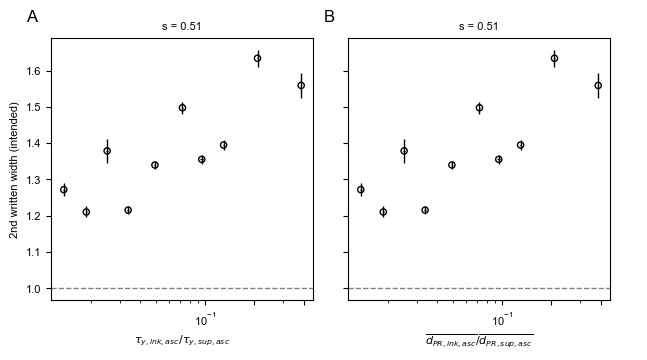

In [66]:
rgt = mp.regressionTableSDT(ms, ms.ss, 'w_w2o', logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

In [12]:
rgt = mp.regressionTableSDT(ms, ms.ss, 'delta_w_write2', Camin=15, logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

,variable,Spearman coeff,Spearman p
1,adjusted spacing,-0.41,4.4e-04


In [14]:
ms.ss.ink_v.unique()

array([10.])

,variable,Spearman coeff,Spearman p
0,spacing_adj,-0.62,1.1e-08


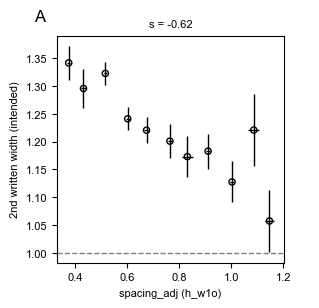

In [68]:
rgt = mp.regressionTableSDT(ms, ms.ss[ms.ss.int_Ca>15], 'w_w2o', logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

,variable,Spearman coeff,Spearman p
1,spacing_adj,-0.12,5.0e-02


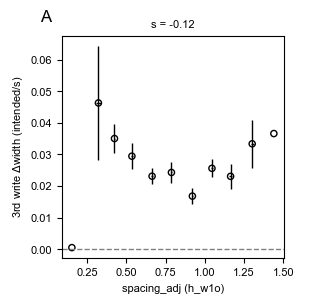

In [70]:
rgt = mp.regressionTableSDT(ms, ms.ss, 'delta_w_write3', logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

## h

In [17]:
rgt = mp.regressionTableSDT(ms, ms.ss, 'delta_h_disturb1', logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

,variable,Spearman coeff,Spearman p
17,"$\overline{d_{PR.ink.asc,adj}}\times \overline...",-0.31,1.01e-07


,variable,Spearman coeff,Spearman p
0,spacing_adj,-0.69,1.7e-82


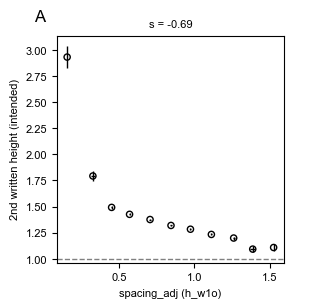

In [80]:
rgt = mp.regressionTableSDT(ms, ms.ss, 'h_w2o', logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

,variable,Spearman coeff,Spearman p
0,$Ca$,-0.55,5.0e-05
1,$Ca_{sup}$,-0.55,5.0e-05
2,$\overline{d_{PR.sup.asc}}$,-0.50,2.8e-04
3,$\overline{d_{PR.ink.desc}}$,-0.50,2.7e-04
4,$\overline{d_{PR.sup.desc}}$,-0.54,6.2e-05
5,$\overline{d_{PR.ink.desc}}\times \overline{d_...,-0.56,4.2e-05
6,$Oh_{sup}$,-0.60,7.0e-06


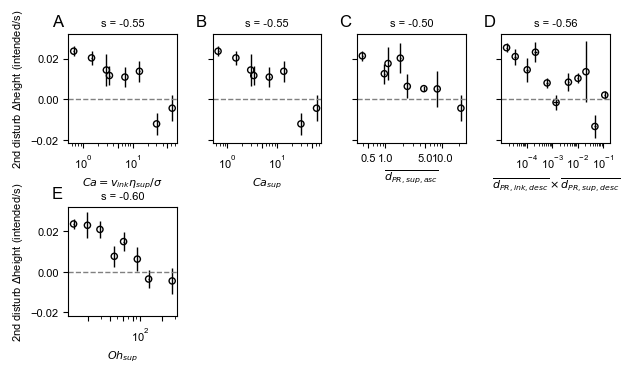

In [91]:
rgt = mp.regressionTableSDT(ms, ms.ss[ms.ss.spacing==1], 'delta_h_disturb2',logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

,variable,Spearman coeff,Spearman p
0,spacing,-0.27,3.2e-06


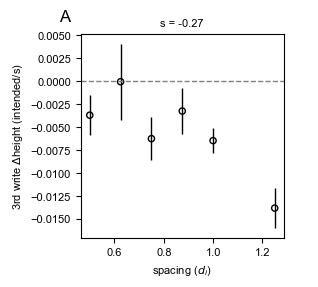

In [95]:
rgt = mp.regressionTableSDT(ms, ms.ss, 'delta_h_write3',logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

## aspectI

,variable,Spearman coeff,Spearman p
0,$Oh_{sup}$,0.53,4.4e-63


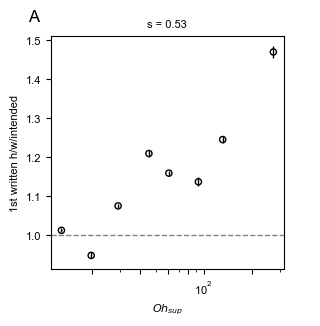

In [97]:
rgt = mp.regressionTableSDT(ms, ms.ss, 'aspectI_w1o',logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

,variable,Spearman coeff,Spearman p
1,$\overline{d_{PR.sup.desc}}$,-0.35,6.4e-10


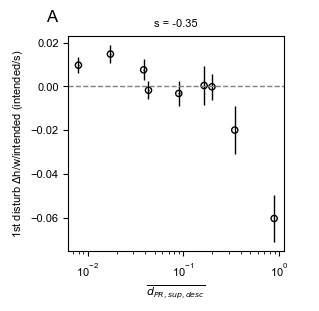

In [98]:
rgt = mp.regressionTableSDT(ms, ms.ss, 'delta_aspectI_disturb1',logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

,variable,Spearman coeff,Spearman p
0,spacing,-0.34,1.9e-17


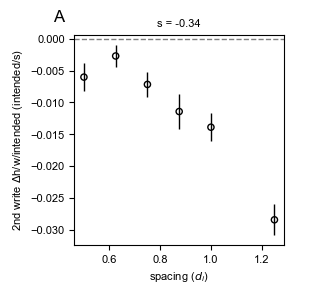

In [99]:
rgt = mp.regressionTableSDT(ms, ms.ss, 'delta_aspectI_write2',logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

In [19]:
rgt = mp.regressionTableSDT(ms, ms.ss, 'xshift_w2o',logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

,variable,Spearman coeff,Spearman p
45,$\eta_{ink}\times \eta_{sup}$,-0.5,2.65e-37


In [20]:
rgt = mp.regressionTableSDT(ms, ms.ss, 'yshift_w2o',logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

,variable,Spearman coeff,Spearman p


## emptiness

,variable,Spearman coeff,Spearman p
0,spacing,0.55,8.1e-46
1,$Ca$,0.51,4.4e-39
2,$Ca_{sup}$,0.51,4.4e-39
3,$\overline{d_{PR.sup.asc}}$,0.50,1.0e-37
4,$\overline{d_{PR.sup.desc}}$,0.54,2.6e-44
5,$\overline{d_{PR.ink.desc}}\times \overline{d_...,0.50,5.4e-38
6,$Oh_{sup}$,0.56,5.0e-48


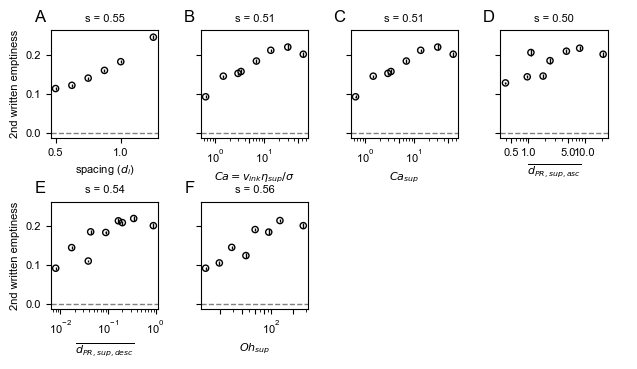

In [109]:
rgt = mp.regressionTableSDT(ms, ms.ss, 'emptiness_w2o',logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

## segments

,variable,Spearman coeff,Spearman p
0,$\tau_{y.ink.asc}/\tau_{y.sup.asc}$,-0.54,1.4e-08
1,$\overline{d_{PR.ink.asc}}/\overline{d_{PR.sup...,-0.54,1.4e-08
2,$\overline{d_{PR.sup.desc}}$,0.51,1.2e-07
3,$Oh_{sup}$,0.53,3.3e-08


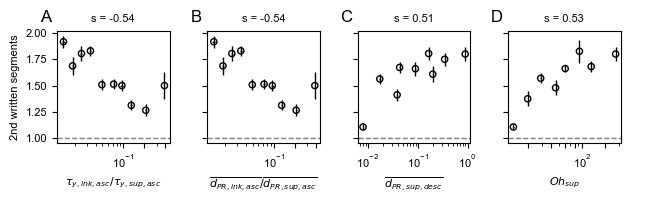

In [113]:
rgt = mp.regressionTableSDT(ms, ms.ss[ms.ss.spacing==1.25], 'segments_w2o',logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)

,variable,Spearman coeff,Spearman p
0,spacing,0.84,2.2e-19
1,spacing_adj,0.83,1.5e-18


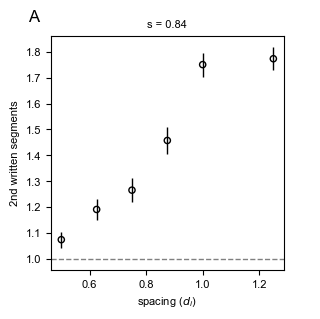

In [117]:
rgt = mp.regressionTableSDT(ms, ms.ss[ms.ss.int_Ca>15], 'segments_w2o',logy=False, printOut=False,  package='pgfplot'
                            , plot=True, yideal=me.ideals(), plotType='paper', export=False, exportFolder=os.path.join(cfg.path.fig, 'SDT'))
display(rgt.df)